# Sea ice seasonality statistics: an example in the Southern Ocean

This notebook calculates days of sea ice advance, retreat, and total sea ice duration over the sea ice season (February 15 to February 14) in the Southern Ocean using outputs from ACCESS-OM2-01.  

**Requirements:** It is suggested you use the `conda/analysis3-20.01` (or later) kernel. This can be defined using the drop down list on the left hand corner, or type `!module load conda/analysis3` in a Python cell.

## Loading relevant modules
These modules are used to access relevant outputs and to manipulate data. 

In [1]:
#This first line will show plots produced by matplotlib inside this Jupyter notebook
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
import pandas as pd
import datetime as dt
import calendar
import os
import re
from dask.distributed import Client, progress
import cmocean as cm                              # Nice colormaps
import cartopy.crs as ccrs                        # For making maps with different projections
import cartopy.feature as cft                     # For adding features to maps

## Parallelising work
Start a cluster that uses multiple cores to parallelise work. Remember that the number of cores cannot exceed the number of CPUs requested when accessing GADI.  
If the line below does not run, skip it. The result is that the job will not be parallelised, but the script will still run.

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:39821 Dashboard: /proxy/8787/status,Cluster Workers: 12 Cores: 12 Memory: 51.54 GB


## Setting up variables to access ACCESS-OM2-01 model outputs

Create a Cosima Cookbook session to access databases

In [3]:
session = cc.database.create_session()

A list of experiment outputs available through the Cosima Cookbook can be accessed using `cc.querying.get_experiments(session)`. Use the argument `all = True` to get a detailed list of available experiments.  
Variables included in each experiment can be obtained through `cc.querying.get_variables(session, experiment, frequency)`.

In [4]:
#Saving the name of experiment from where variables of interest would be obtained. This notebook uses the outputs of the v140 ACCESS-OM2-01 run, which includes wind forcing. 
exp = "01deg_jra55v140_iaf_cycle2"

#Short name of variable of interest - Daily sea ice concentration
varInt = "aice" 

#Define frequency. Remember that frequency and variable name are related to each other (e.g., aice_m has a monthly frequency, while aice has a daily frequency.)
#Frequency and variable name must match, or data loading will fail. 
freq = '1 daily'

Setting date range for the analysis. Note that because times linked to `CICE` outputs require a correction. See the function below for more information.  
Start and end date ranges are given in two different variables: `stime` and `etime` respectively. This is done to make it easy to divide data array into years for the analysis.  

In [5]:
#Give the start and end dates for the analyses. The input must be given as a list, even if it is one item only.
#Dates can be given as full date (e.g., 2010-01-01), just year and month, or just year. If multiple years are to be analysed, ensure both variables have the same length
#Start date
stime = [str(i)+'-02' for i in range(1958, 2019, 1)]
#End date
etime = [str(i)+'-03' for i in range(1959, 2020, 1)]

Loading geographical coordinates in the right format

In [6]:
#Accessing corrected coordinate data to update geographical coordinates in the array of interest
geolon_t = cc.querying.getvar(exp, 'geolon_t', session, n = -1)

## Defining functions

### Accessing ACCESS-OM2-01 outputs 
Defining function that loads data automatically using `cc.querying.getvar()` in a loop. The inputs needed are similar to those for the `cc.querying.getvar()` function, with the addition of inputs to define an area of interest.  
The `getACCESSdata` will achieve the following:  
- Access data for the experiment and variable of interest at the frequency requested and within the time frame specified  
- Apply **time corrections** as midnight (00:00:00) is interpreted differently by the CICE model and the xarray package.
    - CICE reads *2010-01-01 00:00:00* as the start of 2010-01-01, while xarray interprets it as the start of the following day (2010-01-02). To fix this problem, 12 hours are subtracted from the time dimension (also known as *time coordinate*).  
- Latitude and longitude will be corrected in the dataset using the `geolon_t` dataset. The coordinate names are replaced by names that are more intuitive.  
- Minimum and maximum latitudes and longitudes can be specified in the function to access specific areas of the dataset if required. 
By default, the longitudes are set to show the **Southern Ocean**, which is defined as ocean waters south of 45S.

In [7]:
#Frequency, experiment and session do not need to be specified if they were defined in the previous step
def getACCESSdata(var, start, end, exp = exp, freq = freq, ses = session, minlon = geolon_t.xt_ocean.values.min(),\
                  maxlon = geolon_t.xt_ocean.values.max(), minlat = -90, maxlat = -45):
    '''
    Inputs:
    var - Short name for the variable of interest
    start - Time from when data has to be returned
    end - Time until when data has to be returned
    exp - Experiment name
    freq - Time frequency of the data
    ses - Cookbook session
    minlat - minimum latitude from which to return data. If not set, defaults to min latitude in geolon_t data array.
    maxlat - maximum latitude from which to return data. If not set, defaults to max latitude in geolon_t data array.
    minlon - minimum longitude from which to return data. If not set, defaults to -90 to cover the Southern Ocean.
    maxlon - minimum longitude from which to return data. If not set, defaults to -45 to cover the Southern Ocean.
    
    Output:
    Data array with corrected time and coordinates within the specified time period and spatial bounding box.
    '''
    #Accessing data
    vararray = cc.querying.getvar(exp, var, ses, frequency = freq, start_time = start, end_time = end, use_cftime=True)
    #Applying time correction 
    vararray['time'] = vararray.time - dt.timedelta(hours = 12)
    # assign new coordinates to SST dataset 
    #.coords extracts the values of the coordinate specified in the brackets
    vararray.coords['ni'] = geolon_t['xt_ocean'].values
    vararray.coords['nj'] = geolon_t['yt_ocean'].values
    #Rename function from xarray uses dictionaries to change names. Keys refer to current names and values are the desired names
    vararray = vararray.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    #Subsetting data to area of interest
    #Subsetting sea ice concentration array
    vararray = vararray.sel(xt_ocean = slice(minlon, maxlon)).sel(yt_ocean = slice(minlat, maxlat))
    return vararray

### Sea ice seasonality calculations
The `SeaIceAdvArrays` function below was losely based on the `calc_ice_season` function from the `aceecostats` R package developed by Michael Sumner at AAD. This function calculates annual sea ice advance, retreat and total sea ice season duration as defined by Massom et al 2013 [DOI:10.1371/journal.pone.0064756].  
Briefly, if sea ice concentration in any pixel is at least 15% over five consecutive days, sea ice is considered to be *advancing*. Sea ice is *retreating* when its concentration is below 15% in any pixel until the end of the sea ice year. Sea ice *season duration* is the period between day of advance and retreat. **Sea ice year is between February 15 and February 14 the following year.**  
The `SeaIceAdvArrays` function needs three inputs:
- `array` which is the data array on which sea ice seasonality calculations will be performed.
- `dir_out` is the file path to the folder where outputs should be saved.
- `thres` refers to the minimum sea ice concentration threshold. The default is set to 0.15.
- `ndays` is the minimum amount of consecutive days sea ice must be above threshold to be classified as advancing. Default set to 5.  
  
This function will return (if variables are provided) and save (as netcdf files) three data arrays representing sea ice advance, sea ice retreat and sea ice season duration.

In [8]:
def SeaIceAdvArrays(array, dir_out, thres = 0.15, ndays = 5):
    '''
    Inputs:
    array is the data array on which sea ice seasonality calculations will be performed
    dir_out is the file path to the folder where outputs should be saved.
    thres refers to the minimum sea ice concentration threshold. The default is set to 0.15
    ndays is the minimum amount of consecutive days sea ice must be above threshold to be classified as advancing. Default set to 5
    
    Outputs:
    Function saves three data arrays as netcdf files: advance, retreat and season duration. Data arrays can also be saved as variables in the notebook.
    '''
    
    #Extracting maximum and minimum year information to extract data for the sea ice year 
    MinY = str(min(array.indexes['time'].to_datetimeindex().year))
    MaxY = str(max(array.indexes['time'].to_datetimeindex().year))
    
    #Selecting data between Feb 15 to Feb 14 (sea ice year)
    array = array.sel(time = slice(str(MinY)+'-02-15', str(MaxY)+'-02-14'))
    
    ########
    #Preparing masks to perform calculations on areas of interest only
    #Calculate timesteps in dataset (365 or 366 depending on whether it was a leap year or not)
    timesteps = len(array.time.values)

    #Identify pixels (or cells) where sea ice concentration values are equal or above the threshold
    #Resulting data array is boolean. If condition is met then pixel is set to True, otherwise set to False
    threshold = xr.where(array >= thres, True, False)

    #Creating masks based on time over threshold
    #Add values through time to get total of days with ice cover of at least 15% within a pixel
    rsum = threshold.sum('time')

    #Boolean data arrays for masking
    #If the total sum is zero, then set pixel to be True, otherwise set to False. 
    #This identifies pixels where minimum sea ice concentration was never reached.
    noIce = xr.where(rsum == 0, True, False)
    #If the total sum is less than the minimum days, then set pixel to be True, otherwise set to False. 
    #This identifies pixels where sea ice coverage did not meet the minimum consecutive days requirement.
    noIceAdv = xr.where(rsum < ndays, True, False)
    #If the total sum is the same as the timesteps, then set pixel to be True, otherwise set to False.
    #This identifies pixels where sea ice concentration was always at least 15%
    alwaysIce = xr.where(rsum == timesteps, True, False)
    #Remove unused variables
    del rsum

    ########
    #Sea ice advance calculations
    #Use cumulative sums based on time. If pixel has sea ice cover below threshold, then cumulative sum is reset to zero
    adv = threshold.cumsum(dim = 'time')-threshold.cumsum(dim = 'time').where(threshold.values == 0).ffill(dim = 'time').fillna(0)
    #Note: ffill adds nan values forward over a specific dimension

    #Find timestep (date) where the minimum consecutive sea ice concentration was first detected for each pixel
    #Change all pixels that do not meet the minimum consecutive sea ice concentration to False. Otherwise maintain their value.
    advDate = xr.where(adv == ndays, adv, False)
    #Find the time step index where condition above was met.
    advDate = advDate.argmax(dim = 'time')
    #Apply masks of no sea ice advance and sea ice always present.
    advDate = advDate.where(noIceAdv == False, np.nan).where(alwaysIce == False, 1)
    #Remove unused variables
    del adv

    ########
    #Sea ice retreat calculations
    #Reverse threshold data array (time wise) - So end date is now the start date and calculate cumulative sum over time
    ret = threshold[::-1].cumsum('time')
    del threshold
    #Change zero values to 9999 so they are ignored in the next step of our calculation
    ret = xr.where(ret == 0, 9999, ret)
    #Find the time step index where sea ice concentration change to above threshold.
    retDate = ret.argmin(dim = 'time')
    #Substract index from total time length
    retDate = timesteps-retDate
    #Apply masks of no sea ice over threshold and sea ice always over threshold.
    retDate = retDate.where(noIce == False, np.nan).where(alwaysIce == False, timesteps)
    #Remove unused variables
    del ret
    
    ########
    #Sea ice duration
    durDays = retDate-advDate
    #Remove unused variables
    del noIce, noIceAdv, alwaysIce
    
    ########
    #Adding a time dimension to newly created arrays and removing unused dimensions
    def addTime(array, year):
        #Create a time variable to add as dimension to each array - Only one timestep included
        time = pd.date_range(str(year)+'-02-15', str(year)+'-02-16', freq = 'D', closed = 'left')
        #Add time dimension to data array
        x = array.expand_dims({'time': time}).assign_coords({'time': time})
        #Remove dimensions that are not needed
        x = x.drop('TLON').drop('TLAT').drop('ULON').drop('ULAT')
        #Return 
        return x
         
    #Applying function
    advDate2 = addTime(advDate, MinY)
    retDate2 = addTime(retDate, MinY)
    durDate = addTime(durDays, MinY)
    del advDate, retDate, durDays
    
    ########
    #Save corrected outputs as netcdfiles
    #Define output paths
    advpath = os.path.join(dir_out, ('SeaIceAdv_' + MinY + '-' + MaxY + '.nc'))
    retpath = os.path.join(dir_out, ('SeaIceRet_' + MinY + '-' + MaxY + '.nc'))
    durpath = os.path.join(dir_out, ('SeaIceDur_' + MinY + '-' + MaxY + '.nc'))
    
    #Save files simultaneously
    xr.save_mfdataset(datasets = [advDate2.to_dataset(), retDate2.to_dataset(), durDate.to_dataset()], paths = [advpath, retpath, durpath])
    
    #Return data arrays as outputs
    return (advDate2, retDate2, durDate)

### Sea ice seasonality plots
The `SeaIceAdvMap` function plots sea ice advance, retreat and season duration in one panel.  
The `SeaIceAdvMap` function needs the inputs:
- `adv` which is a two dimensional data array containing sea ice advance information. Output 1 from `SeaIceAdvArrays` function.
- `ret` which is a two dimensional data array containing sea ice retreat information. Output 2 from `SeaIceAdvArrays` function.
- `dur` which is a two dimensional data array containing sea ice season duration. Output 3 from `SeaIceAdvArrays` function.
- `dir_out` is the file path to the folder where outputs should be saved.  
  
Optional inputs `**colPal` include:
- `palette` which defines the colour palette to be used. It expects a matplotlib colormap (e.g., `palette = cm.cm.ice`).  
- `anom` which if set to `True` will change the figure title and file name output to include the word ***anomaly***.
- `anom_std` is a boolean variable that if set to `True` will change figure titles and file names to include the ***standarised anomaly***.  
If data arrays provided do not contain a time dimension after means have been calculated. The years included in the analysis can be manually provided:
- `MinY` is the first year included in data array
- `MaxY` is the final year included in data array
  
This function will save a composite figure (png format) with sea ice advance, retreat and season duration.

In [7]:
def SeaIceAdvMap(adv, ret, dur, dir_out, **colPal):
    '''
    Inputs:
    adv - which is a two dimensional data array containing sea ice advance information. Output 1 from `SeaIceAdvArrays` function.
    ret - which is a two dimensional data array containing sea ice retreat information. Output 2 from `SeaIceAdvArrays` function.
    dur - which is a two dimensional data array containing sea ice season duration. Output 3 from `SeaIceAdvArrays` function.
    dir_out - is the file path to the folder where outputs should be saved.  
    
    Optional inputs `**colPal` include:
    palette - which defines the colour palette to be used. It expects a string a matplotlib colormap (e.g., palette = cm.cm.ice).  
    anom - which if set to `True` will change the figure title and file name output to include the word 'anomaly'.  
    anom_std - boolean variable that if set to `True` will change figure titles and file names to include the 'standarised anomaly'
    
    If data arrays provided do not contain a time dimension after means have been calculated. The years included in the analysis can be manually provided:
    MinY - first year included in data array
    MaxY - final year included in data array
    
    Outputs:
    Composite png figure showing sea ice advance, retreat and total season duration.
    '''
    
    #######################################################
    #Colormap settings
    #Calling libraries to edit long and lat labels
    import matplotlib.ticker as mticker
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    import matplotlib.gridspec as gridspec
    
    #Check if the 'palette' argument has been defined
    if 'palette' in colPal.keys():
        #Load the colour palette defined in the 'palette' argument
        pal_map_adv = colPal['palette']
        pal_map_ret = colPal['palette'][::-1]
    #If 'palette' argument has not been defined, then use cmocean ice palette as default
    else:
        pal_map_adv = cm.cm.ice
        pal_map_ret = cm.cm.ice[::-1]
        
    if 'anom' in colPal.keys() or 'anom_std' in colPal.keys():
        pal_map_adv = pal_map_ret
        
    #Nan values will show as light grey
    pal_map_adv.set_bad(color = '#e0e0e0', alpha = 0.3)
    pal_map_ret.set_bad(color = '#e0e0e0', alpha = 0.3)
    
    #Plotting maps
    #Change global font and font size
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 14
    
    #Extracting maximum and minimum year information to add to plot titles
    if 'MinY' in colPal.keys() and 'MaxY' in colPal.keys():
        MinY = str(colPal['MinY'])
        MaxY = str(colPal['MaxY'])
    else:
        MinY = str(adv.indexes['time'].year.min())
        MaxY = str(adv.indexes['time'].year.min()+1)
    
    ####################################################### 
    #Calculate timesteps in dataset
    if calendar.isleap(int(MinY)) == True:
        timesteps = 366
    else:
        timesteps = 365
    #######################################################
        
    #Define projection to polar
    projection = ccrs.SouthPolarStereo()

    #Create variable containing the Antarctic continent - 50m is medium scale
    land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', linewidth = 0.5)
    
    if 'anom' in colPal.keys():
        #Define the contour lines to be shown in the graph. From 1 to length of timesteps+1 and increasing by 1
        levels = np.arange(-150, 151, 10)
        #Colourbar tick labels
        cbar_ticks = [int(i) for i in np.arange(-150, 151, 50)]
    elif 'anom_std' in colPal.keys():
        #Define the contour lines to be shown in the graph. From 1 to length of timesteps+1 and increasing by 1
        levels = np.arange(-6, 7, 1)
        #Colourbar tick labels
        cbar_ticks = [int(i) for i in np.arange(-6, 7, 1)]
    else:
        #Define the contour lines to be shown in the graph. From 1 to length of timesteps+1 and increasing by 1
        levels = np.arange(1, timesteps+1, 10)
        #Colourbar tick labels
        cbar_ticks = [int(i) for i in np.arange(5, timesteps+1, 20)]
     
    ########
    #Create composite figure using a grid
    #Top left panel shows sea ice advance, top right panel shows sea ice retreat and bottom panel shows sea ice season duration
    fig = plt.figure(figsize = (17, 15))
    #Create a grid layout to place all subplots in one figure - 4x4 grid created to center bottom plot
    gs = gridspec.GridSpec(nrows = 4, ncols = 4)
       
    ########
    #Plot advancing sea ice day
    #Add subplot in the first two rows and first two columns, so it is aligned to the top left
    ax_adv = fig.add_subplot(gs[:2, :2], projection = projection)
    #Fix if time dimension shows in data that should be 2D
    if len(adv.dims) > 2:
        adv = adv[0]
    #Add contour plot of sea ice advance
    p_adv = adv.plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = ax_adv,
                  #Setting color palette and contour levels
                  add_colorbar = False, levels = levels, cmap = pal_map_adv, 
                  #Remove colourbar to allow for further manipulation
                  transform = ccrs.PlateCarree())
    #Add subplot title
    ax_adv.set_title('Sea Ice Advance', y = 1.01)
    
    ########
    #Plot retreating sea ice day
    #Add subplot along the first two rows and the last two columns, so it is aligned to the top right
    ax_ret = fig.add_subplot(gs[:2, 2:], projection = projection)
    #Fix if time dimension shows in data that should be 2D
    if len(ret.dims) > 2:
        ret = ret[0]
    p_ret = ret.plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = ax_ret,
                  #Setting color palette and contour levels
                  cmap = pal_map_ret, levels = levels, add_colorbar = False,
                  #Remove colourbar to allow for further manipulation
                  transform = ccrs.PlateCarree())
    #Add subplot title
    ax_ret.set_title('Sea Ice Retreat', y = 1.01)
    
    ######    
    #Plot sea ice duration
    #Add subplot along the last two rows and in the middle two columns (1 and 2)
    ax_dur = fig.add_subplot(gs[2:4, 1:3], projection = projection)
    #Fix if time dimension shows in data that should be 2D
    if len(dur.dims) > 2:
        dur = dur[0]
    #Add contour plot of season duration
    p_dur = dur.plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = ax_dur, 
                  #Setting color palette and contour levels
                  cmap = pal_map_ret, levels = levels, add_colorbar = False,
                  #Remove colourbar to allow for further manipulation
                  transform = ccrs.PlateCarree())
    #Add subplot title
    ax_dur.set_title('Sea Ice Season Duration', y = 1.01)
    #Ensure the same aspect is mantained
    ax_dur.set_aspect('equal')
     
    ########
    #Changing colourbars
    #Sea ice advance
    cb_adv = fig.colorbar(p_adv, ax = ax_adv)
    #Set title for colourbar
    cb_adv.ax.set_ylabel('Day of advance')
    
    #Sea ice retreat
    cb_ret = fig.colorbar(p_ret, ax = ax_ret)
    #Set title for colourbar
    cb_ret.ax.set_ylabel('Day of retreat')
     
    #Sea ice season duration
    cb_dur = fig.colorbar(p_dur, ax = ax_dur)
    #Set title for colourbar
    cb_dur.ax.set_ylabel('Duration of sea ice season')
    
    #Setting colourbar ticks and labels
    for cb in [cb_adv, cb_ret, cb_dur]:
        cb.set_ticks(cbar_ticks)
        cb.set_ticklabels(cbar_ticks)

    ########
    #Changing other plot parameters
    for ax in [ax_dur, ax_adv, ax_ret]:
        #Remove x and y axes labels
        ax.set_ylabel("")
        ax.set_xlabel("")
        #Coastlines to appear
        ax.coastlines(resolution = '50m')
        #Add feature loaded at the beginning of this section
        ax.add_feature(land_50m)
        #Set the extent of maps
        ax.set_extent([-280, 80, -80, -50], crs = ccrs.PlateCarree())
        #Adding gridlines gridlines - Removing any labels inside the map on the y axis
        gl = ax.gridlines(draw_labels = True, y_inline = False, color = "#b4b4b4", alpha = 0.6)
        #Locate longitude ticks - Set to every 30 deg
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
        #Give longitude labels the correct format for longitudes
        gl.xformatter = LONGITUDE_FORMATTER
        #Set rotation of longitude labels to zero
        gl.xlabel_style = {'rotation': 0}
        #Set latitude labels to be transparent
        gl.ylabel_style = {'alpha': 0}
        #Add space between axis ticks and labels for x and y axes
        gl.xpadding = 8
        gl.ypadding = 8
        gl.xlabels_left = False
        gl.ylabels_right = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = True
        #Only include labels on the left side of the subplot if it is not the sea ice retreat subplot
        if ax != ax_ret:
            gl.ylabels_left = True
        elif ax == ax_ret:
            gl.ylabels_left = False
    
    ########
    #Save maps as png files    
    os.makedirs(dir_out, exist_ok = True)
    if 'anom' in colPal.keys():
        #Set title for composite figure. Move the title along the y axis so it is not too far from 
        fig.suptitle('Sea ice seasonality anomalies between February 15, ' + str(MinY) + ' and February 14, '+ str(MaxY), y = 0.925, fontsize = 16)
        #Define output paths
        path_fig = os.path.join(dir_out, ('MapSeaIceSeasonalAnom_' + MinY + '-' + MaxY + '.png'))        
    elif 'anom_std' in colPal.keys():
        #Set title for composite figure. Move the title along the y axis so it is not too far from 
        fig.suptitle('Sea ice seasonality standarised anomalies between February 15, ' + str(MinY) + ' and February 14, '+ str(MaxY), y = 0.925, fontsize = 16)
        #Define output paths
        path_fig = os.path.join(dir_out, ('MapSeaIceSeasonalStdAnom_' + MinY + '-' + MaxY + '.png'))        
    else:
        fig.suptitle('Sea ice seasonality between February 15, ' + str(MinY) + ' and February 14, '+ str(MaxY), y = 0.925, fontsize = 16)
        #Automatically saving figures to local folder
        #Define output paths
        path_fig = os.path.join(dir_out, ('MapSeaIceSeasonal_' + MinY + '-' + MaxY + '.png'))
    
    plt.savefig(path_fig, dpi = 300)

### Obtaining a list of files containing advance, retreat and total sea ice duration
The function `getFileList` can be used to calculate baseline means or to extract files for any other time period. It takes the following inputs:
- `filein` which refers to the location of the folder containing the netcdf files to be combined for further calculations
- `yrs` which is a numpy array containing a list of the years of interest
  
The function provides three outputs: `adv_list`, `ret_list`, `sea_list`, each of which contains a list of files for sea ice advance, retreat and duration for the time period of interest

In [9]:
def getFileList(filein, yrs):
    '''
    Inputs:
    filein - refers to the file path of the folder containing the datasets to be used in calculations.
    yrs - is a numpy array containing a list of years of interest for calculations.
      
    Outputs:
    Three lists: adv_list, ret_list, and sea_list which contain the list of files containing sea ice advance, retreat and total season duration respectively.
    '''
    #List netcdf files containing sea ice seasonality data
    filelist = os.listdir(filein)
 
    #Extract files for baseline years
    basefiles = []
    for i in filelist:
        for j in yrs:
            if i[10:14] == str(j):
                basefiles.append(i)
    #Remove variables no longer in use
    del filelist

    #Separate files based on whether they contain information about sea ice advance, retreat or season. Order them alphabetically.
    adv_list = sorted([i for i in basefiles if 'Adv' in i])
    ret_list = sorted([i for i in basefiles if 'Ret' in i])
    sea_list = sorted([i for i in basefiles if 'Dur' in i])
    #Remove variables no longer in use
    del basefiles
    
    #Return file lists
    return adv_list, ret_list, sea_list

### Create three dimensional data arrays by combining multiple netcdf files
In case various data sets need to be combined into one, the function `combineData` can be used to achieve this. This function has two inputs:
- `filepath` refers to the location of the netcdf files that will be used to create the combined data array
- `filelist` refers to the names of the files that will be combined  
- `dir_out` is the file path of the folder where combined data arrays will be saved  
  
The function returns one combined data array which includes a `time` dimension. The value of the time dimension refers to the start of the sea ice season.

In [8]:
def combineData(filepath, filelist, dir_out):
    '''
    Inputs:
    filepath - refers to the file path of the folder containing the netcdf files to be combined into a single data array.
    filelist - contains the actual names of the netcdf files that will be combined..
    dir_out - file path of the folder where combined data arrays will be saved
      
    Outputs:
    Three dimensional data array containing all files provided in the filelist input. The data array is saved to the path provided in dir_out and it can also be assigned to a variable.
    '''
    #Create variable to hold combined data arrays
    combData = []
    #Create loop based on the total length of filelist
    for i in np.arange(0, len(filelist)):
        #Open data array
        x = xr.open_dataarray(os.path.join(filepath, filelist[i]), autoclose = True)
        #Put all files in one variable
        combData.append(x)
        
    #Create one data array with the data contained in the combined variable
    combined = xr.concat(combData, dim = 'time')
    combined.to_netcdf(os.path.join(dir_out, (filelist[0][0:15]+filelist[-1][15:19]+'.nc')))
    return combined

### Calculating anomalies from baseline period
The function `AnomCalc` calculates anomalies from a baseline period. It has the option to calculate standarised anomalies. It takes the following inputs:
- `array` which refers to the data array containing information for the period being compared to the baseline. It could include just one year or multiple years (decades)
- `clim_array` is a three dimensional array containing data over the baseline period from which anomalies will be calculated
- `std_anom` is a boolean variable that if set to `True` results in standarised anomalies being calculated  
  
The function provides one output, which is a data array containing the calculated anomalies.

In [10]:
def AnomCalc(array, clim_array, std_anom = False):
    '''
    Inputs:
    array - refers to a data array containing information for the period being compared to the baseline. It could include just one year or multiple years (decades)
    clim_array - three dimensional array containing data over the baseline period from which anomalies will be calculated
    std_anom - boolean variable that if set to True will result in standarised anomalies being calculated
      
    Outputs:
    Data array containing anomalies.
    '''
    
    #Calculate long term mean of array
    m_climarray = clim_array.mean('time')
    
    #Calculate mean of comparison array in case it includes more than one year
    if len(array.dims) > 2:
        m_array = array.mean('time')
    else:
        m_array = array
    
    #Calculate anomalies
    #Standarised anomalies
    if std_anom == True:
        s_climarray = clim_array.std('time')
        anom = (m_array - m_climarray)/s_climarray
    #Non-standarised anomalies
    elif std_anom == False:
        anom = m_array - m_climarray
    
    #Return anomalies
    return anom

## Applying functions

### Sea ice season calculations and plots
Looping through each year in data array and applying the sea ice season calculations and plotting functions.  
**Note:** If sea ice season calculations have already been saved to disk through the `SeaIceAdvArrays` function, the netcdf files can be loaded as: `adv = xr.open_dataarray('filepath/filename.nc')`. The `SeaIceAdvMap` can then be run using the uploaded files as inputs.

In [34]:
dir_out = 'PROVIDE_FILE_PATH'
dir_out2 = 'PROVIDE_FILE_PATH'

for i in np.arange(0, len(stime)):
    SO = getACCESSdata(varInt, stime[i], etime[i], freq = freq)
    adv, ret, sea = SeaIceAdvArrays(array = SO, dir_out = dir_out)
    del SO
    SeaIceAdvMap(adv, ret, sea, dir_out2, palette = cm.cm.dense)
    del adv, ret, sea

### Combining multiple netcdf files into a single data array
Using the `combineData` function to create a single three dimensional data array combine multiple netcdf files.

In [16]:
# Applying function
dir_out = r'PROVIDE_FILE_PATH'
adv = combineData(filein, adv_list, dir_out)
ret = combineData(filein, ret_list, dir_out)
dur = combineData(filein, dur_list, dir_out)

### Creating maps from netcdf files
If using saved netcdf files, maps can be created with the following code

In [6]:
#File path of folder containing netcdf files
filein = r'PROVIDE_FILE_PATH'
dir_out = r'PROVIDE_FILE_PATH'
#Define years of interest
yrs = np.arange(1965, 2019)

#Apply the getFileList function to create maps for all years of interest
adv_list, ret_list, dur_list = getFileList(filein, yrs)

#Creating a loop to apply the SeaIceAdvMap function to all files
for i in np.arange(0, len(adv_list)):
    #Extract minimum and maximum years from the file name
    minYear = re.split('_|\.|-', adv_list[i])[1]
    maxYear = re.split('_|\.|-', adv_list[i])[2]
    #Load netcdf file as data array for calculations
    adv = xr.load_dataarray(os.path.join(filein, adv_list[i]))
    ret = xr.load_dataarray(os.path.join(filein, ret_list[i]))
    sea = xr.load_dataarray(os.path.join(filein, sea_list[i]))
    #Apply function
    SeaIceAdvMap(adv, ret, sea, dir_out, palette = cm.cm.dense, MinY = minYear, MaxY = maxYear)
    #Delete variables no longer in use
    del adv, ret, sea

## Calculating sea ice seasonality anomalies
Anomalies are calculated per year and per season from the baseline. The time period chosen to calculate long-term mean SST, which will serve as a baseline, is between 1979 and 2008 (first 30 years of satellite records).  

In [14]:
#Get list of files for the baseline period: 1979-2008
#File path of folder containing netcdf files
filein = r'PROVIDE_FILE_PATH'
#Years of interest
yrs = np.arange(1979, 2009)

adv_list, ret_list, dur_list = getFileList(filein, yrs)

In [47]:
#Combine files contained in the above lists into a three dimensional data array
dir_out = r'PROVIDE_FILE_PATH'
base_adv = combineData(filein, adv_list, dir_out)
base_ret = combineData(filein, ret_list, dir_out)
base_dur = combineData(filein, dur_list, dir_out)

### Yearly anomaly calculation

In [43]:
#Get list of files for period of interest: 1965-2018
#File path of folder containing netcdf files
filein = r'PROVIDE_FILE_PATH'
#Years of interest
yrs = np.arange(1965, 2019)

adv_list, ret_list, dur_list = getFileList(filein, yrs)

In [13]:
dir_out = r'PROVIDE_FILE_PATH'

for i in np.arange(0, len(adv_list)):
    #Open yearly files
    adv = xr.open_dataarray(os.path.join(filein, adv_list[i]), autoclose = True)
    ret = xr.open_dataarray(os.path.join(filein, ret_list[i]), autoclose = True)
    dur = xr.open_dataarray(os.path.join(filein, dur_list[i]), autoclose = True)
    
    #Calculate anomalies
    a_adv = AnomCalc(adv, base_adv, std_anom = True)
    a_ret = AnomCalc(ret, base_ret, std_anom = True)
    a_dur = AnomCalc(dur, base_dur, std_anom = True)
    
    #Provide min and max year info
    MinY = re.split('_|\.|-', adv_list[i])[1]
    MaxY = re.split('_|\.|-', adv_list[i])[2]
    
    #Remove unused variables
    del adv, ret, dur
    
    SeaIceAdvMap(a_adv, a_ret, a_dur, dir_out, palette = cm.cm.dense, anom_std = True, MinY = MinY, MaxY = MaxY)

### Decadal anomaly calculations

In [24]:
#Load combined baseline netcdf files
base_adv = xr.open_dataarray(r'PROVIDE_FILE_PATH', autoclose = True)
base_ret = xr.open_dataarray(r'PROVIDE_FILE_PATH', autoclose = True)
base_dur = xr.open_dataarray(r'PROVIDE_FILE_PATH', autoclose = True)

In [19]:
#Get list of files for each decade between 1965 and 2018
#File path of folder containing netcdf files
filein = r'PROVIDE_FILE_PATH'
#Years of interest
yrs = np.arange(1965, 2019)
#Apply function
adv_list, ret_list, dur_list = getFileList(filein, yrs)

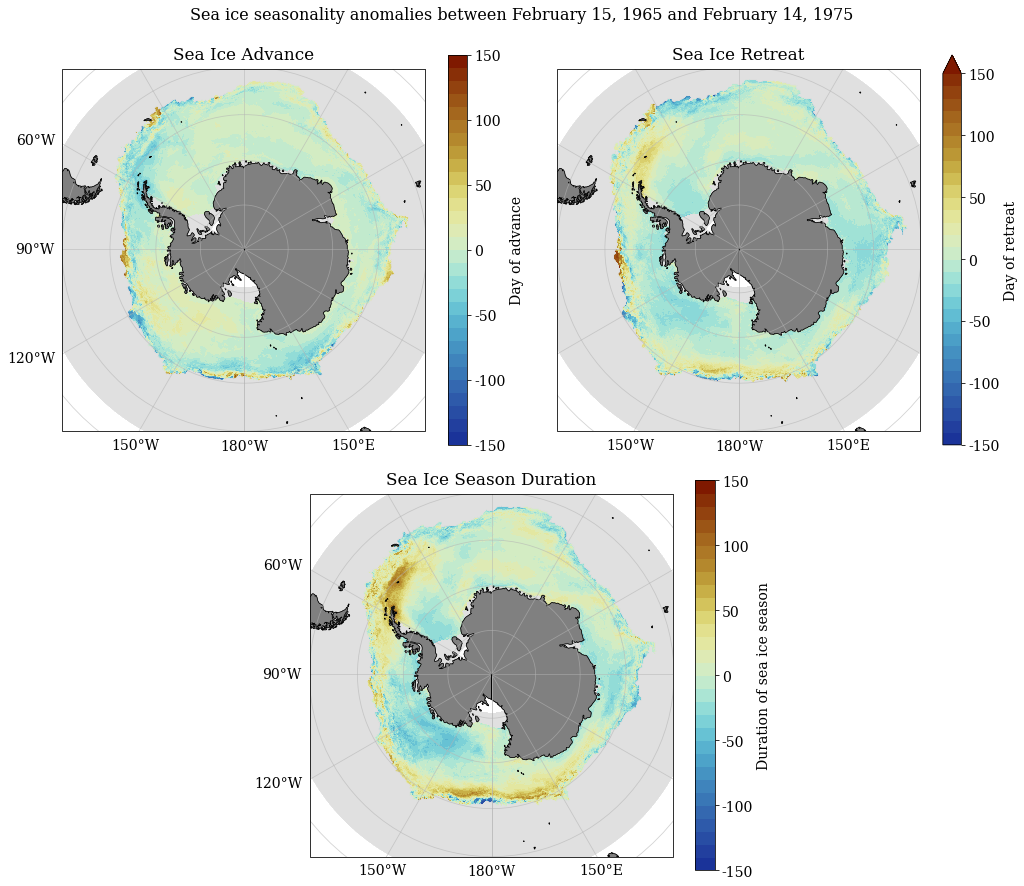

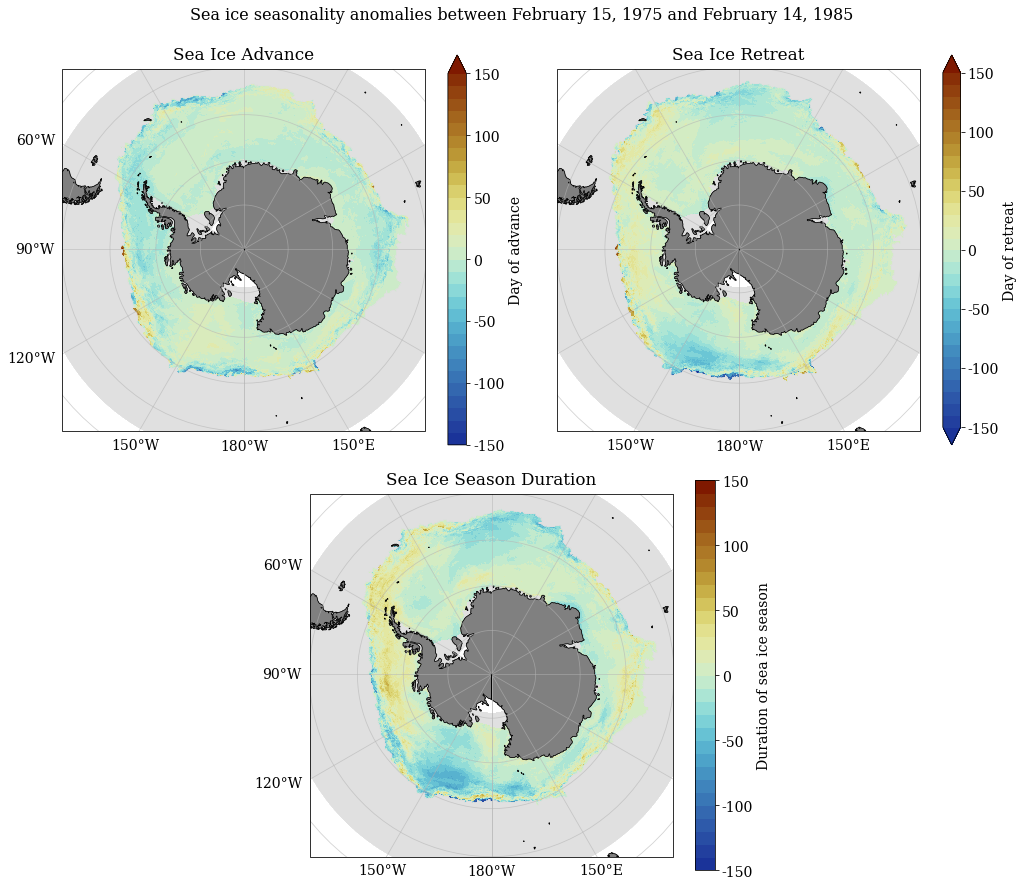

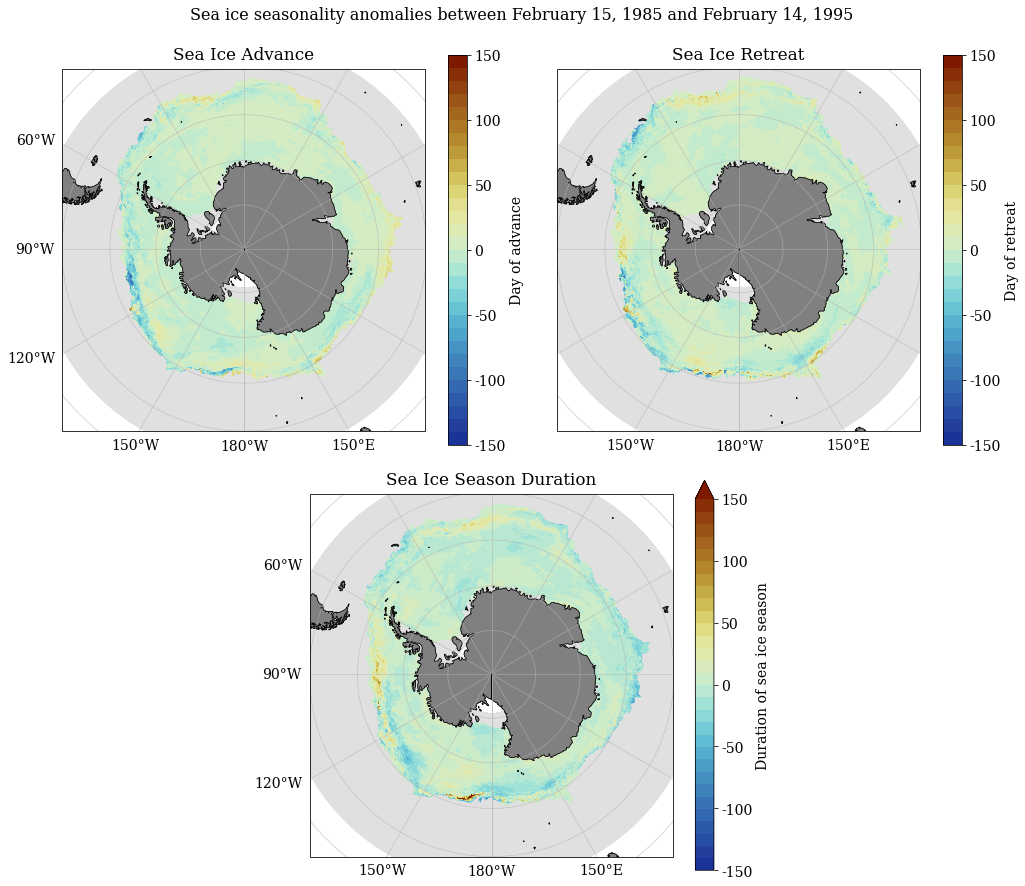

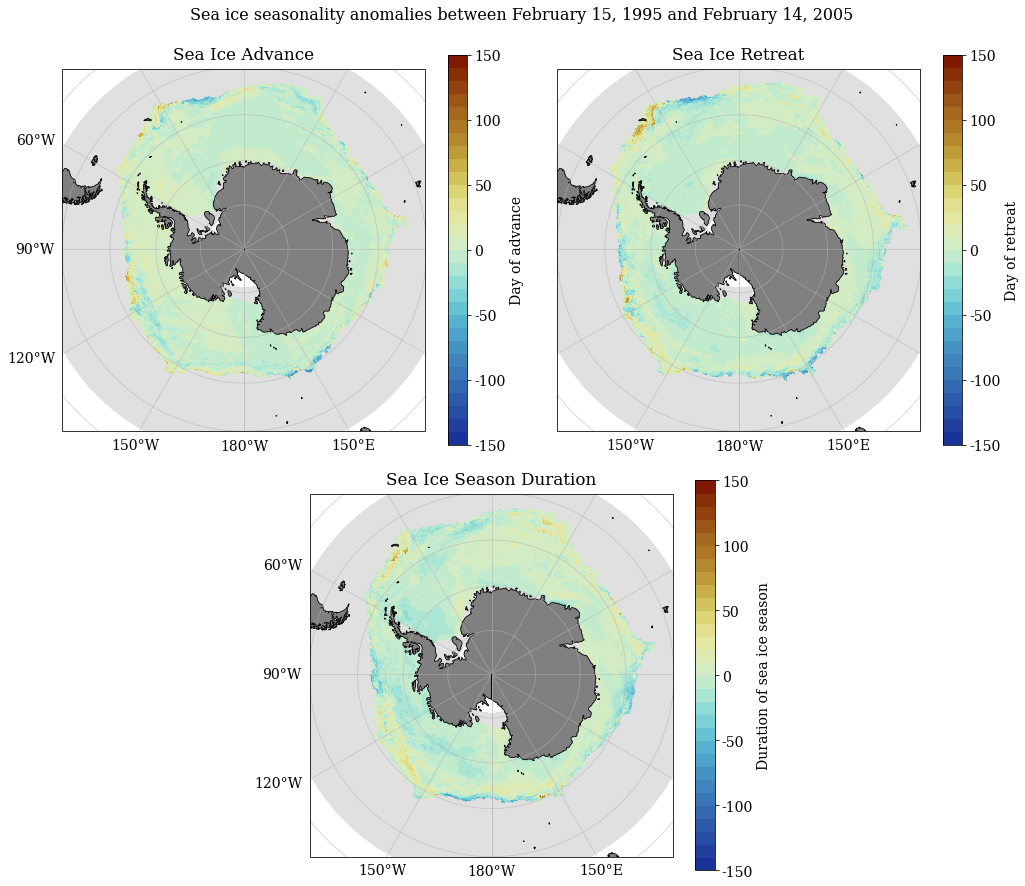

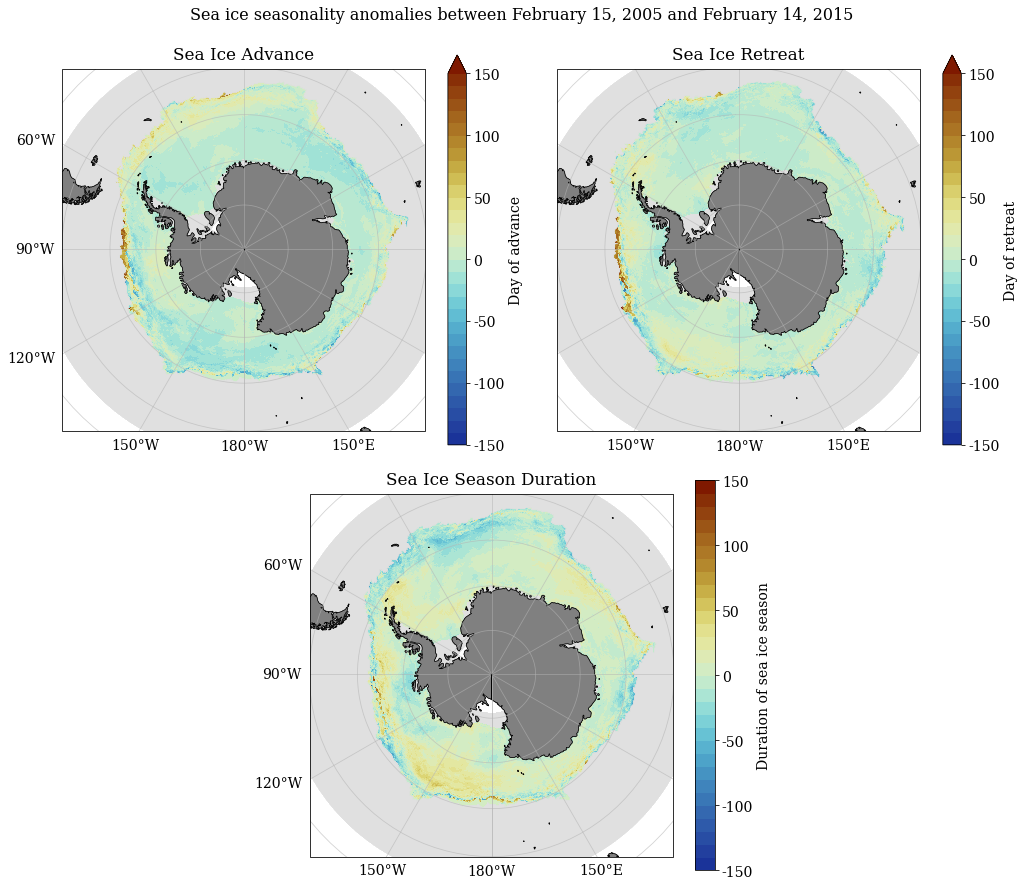

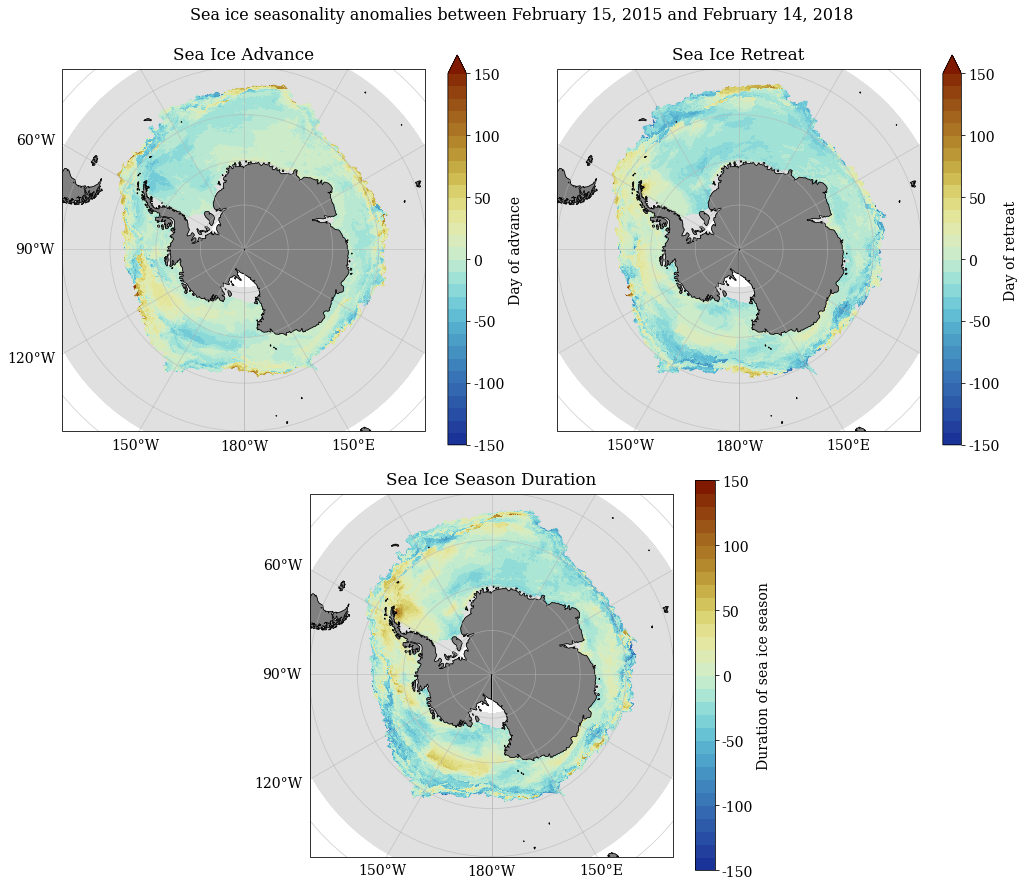

In [26]:
dir_out = r'PROVIDE_FILE_PATH'

for i in np.arange(0, len(adv_list)):
    #Open yearly files
    adv = xr.open_dataarray(os.path.join(filein, adv_list[i]), autoclose = True)
    ret = xr.open_dataarray(os.path.join(filein, ret_list[i]), autoclose = True)
    dur = xr.open_dataarray(os.path.join(filein, dur_list[i]), autoclose = True)
    
    #Calculate anomalies
    a_adv = AnomCalc(adv, base_adv, std_anom = False)
    a_ret = AnomCalc(ret, base_ret, std_anom = False)
    a_dur = AnomCalc(dur, base_dur, std_anom = False)
    
    #Provide min and max year info
    MinY = re.split('_|\.|-', adv_list[i])[1]
    MaxY = re.split('_|\.|-', adv_list[i])[2]
    
    #Remove unused variables
    del adv, ret, dur
    
    SeaIceAdvMap(a_adv, a_ret, a_dur, dir_out, palette = cm.cm.dense, anom = True, MinY = MinY, MaxY = MaxY)

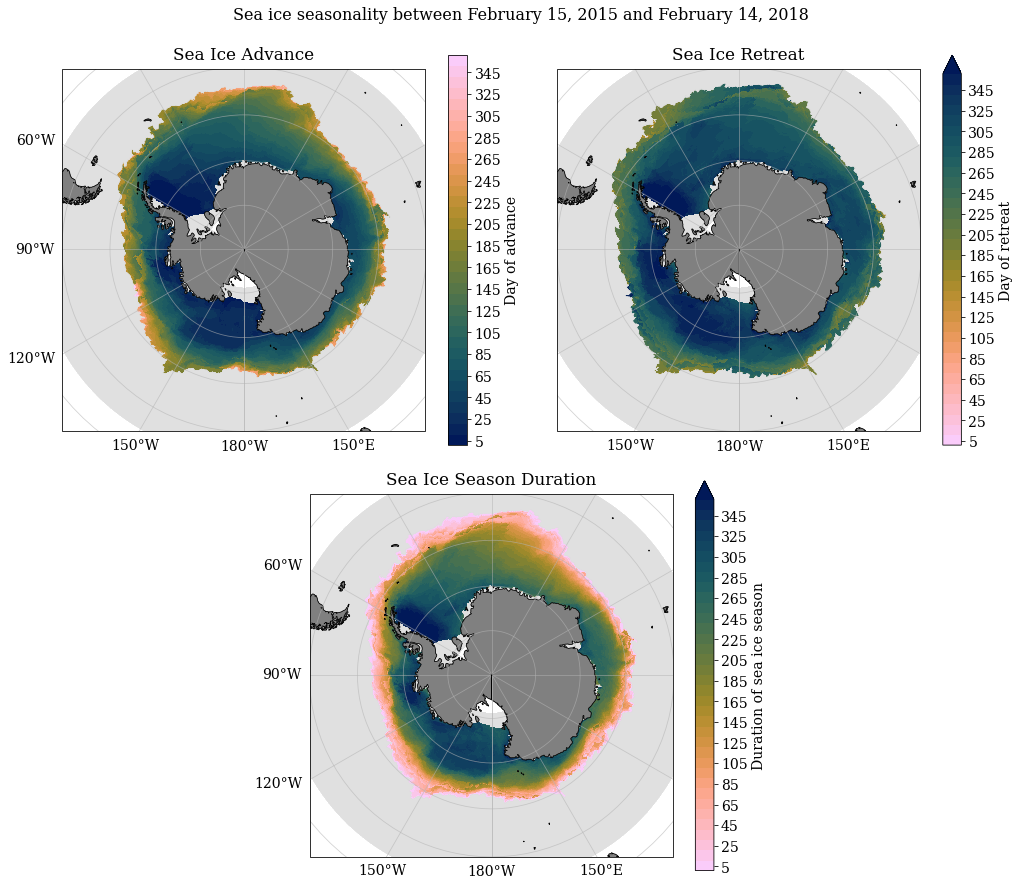

In [84]:
#Plotting means over time periods defined in previous step
SeaIceAdvMap(adv.mean('time'), ret.mean('time'), dur.mean('time'), yrs[0], yrs[-1]+1, palette = cm.cm.dense)

### Calculating mean weighted sea ice seasonality values and comparing against unweighted means

The `weightedMeans` function takes three 3-dimensional data arrays to calculate weighted means over time:
- `adv` which contains sea ice advance data for multiple time steps
- `ret` which contains sea ice retreat data for multiple time steps
- `dur` which contains sea ice season duration data for multiple time steps  
  
Three outputs are given `adv_weighted_mean`, `ret_weighted_mean` and `dur_weighted_mean` which are 2-dimensional data arrays containing the weighted means calculated over time.

In [27]:
def weightedMeans(adv, ret, dur, dir_out):
    '''
    Inputs:
    adv refers to a data array that contains sea ice advance data for multiple time steps
    ret refers to a data array that contains sea ice retreat data for multiple time steps
    dur refers to a data array that contains sea ice season duration data for multiple time steps
      
    Outputs:
    Three outputs are given `adv_weighted_mean`, `ret_weighted_mean` and `dur_weighted_mean` which are 2-dimensional data arrays containing the weighted means calculated over time.
    '''
    
    #Minimum and maximum years
    MinY = str(adv.indexes['time'].year.min())
    MaxY = str(adv.indexes['time'].year.max())
    
    #Creating a variable with numbers of days within each year
    days = adv.time.dt.days_in_month
    #Change values to 366 if there are 29 days, otherwise change to 365
    days = xr.where(days == 29, 366, 365)
    #Calculate weights dividing each timestep to the total
    weights = days/days.sum()
    weights.name = "weights"
    #Remove variables not in use
    del days

    #Apply weights along time axis
    adv_weighted = adv.weighted(weights)
    ret_weighted = ret.weighted(weights)
    dur_weighted = dur.weighted(weights)

    #Calculate weighted means
    adv_weighted_mean = adv_weighted.mean('time')
    ret_weighted_mean = ret_weighted.mean('time')
    dur_weighted_mean = dur_weighted.mean('time')

    #Saving weighted means
    os.makedirs(dir_out, exist_ok = True)
    adv_weighted_mean.to_netcdf(os.path.join(dir_out, ('SeaIceAdvWeightedMean_'+ MinY +'-' + MaxY +'.nc')))
    ret_weighted_mean.to_netcdf(os.path.join(dir_out, ('SeaIceRetWeightedMean_'+ MinY +'-' + MaxY +'.nc')))
    dur_weighted_mean.to_netcdf(os.path.join(dir_out, ('SeaIceDurWeightedMean_'+ MinY +'-' + MaxY +'.nc')))

    #Remove variables not in use
    del adv_weighted, ret_weighted, dur_weighted, weights
    
    #Return weighted means
    return adv_weighted_mean, ret_weighted_mean, dur_weighted_mean

In [29]:
#Directory where all files will be saved
dir_out = r'PROVIDE_FILE_PATH'

#Applying function to calculate weighted means
adv_w, ret_w, dur_w = weightedMeans(base_adv, base_ret, base_dur, dir_out)

**Plotting comparisons between weighted and unweighted means**

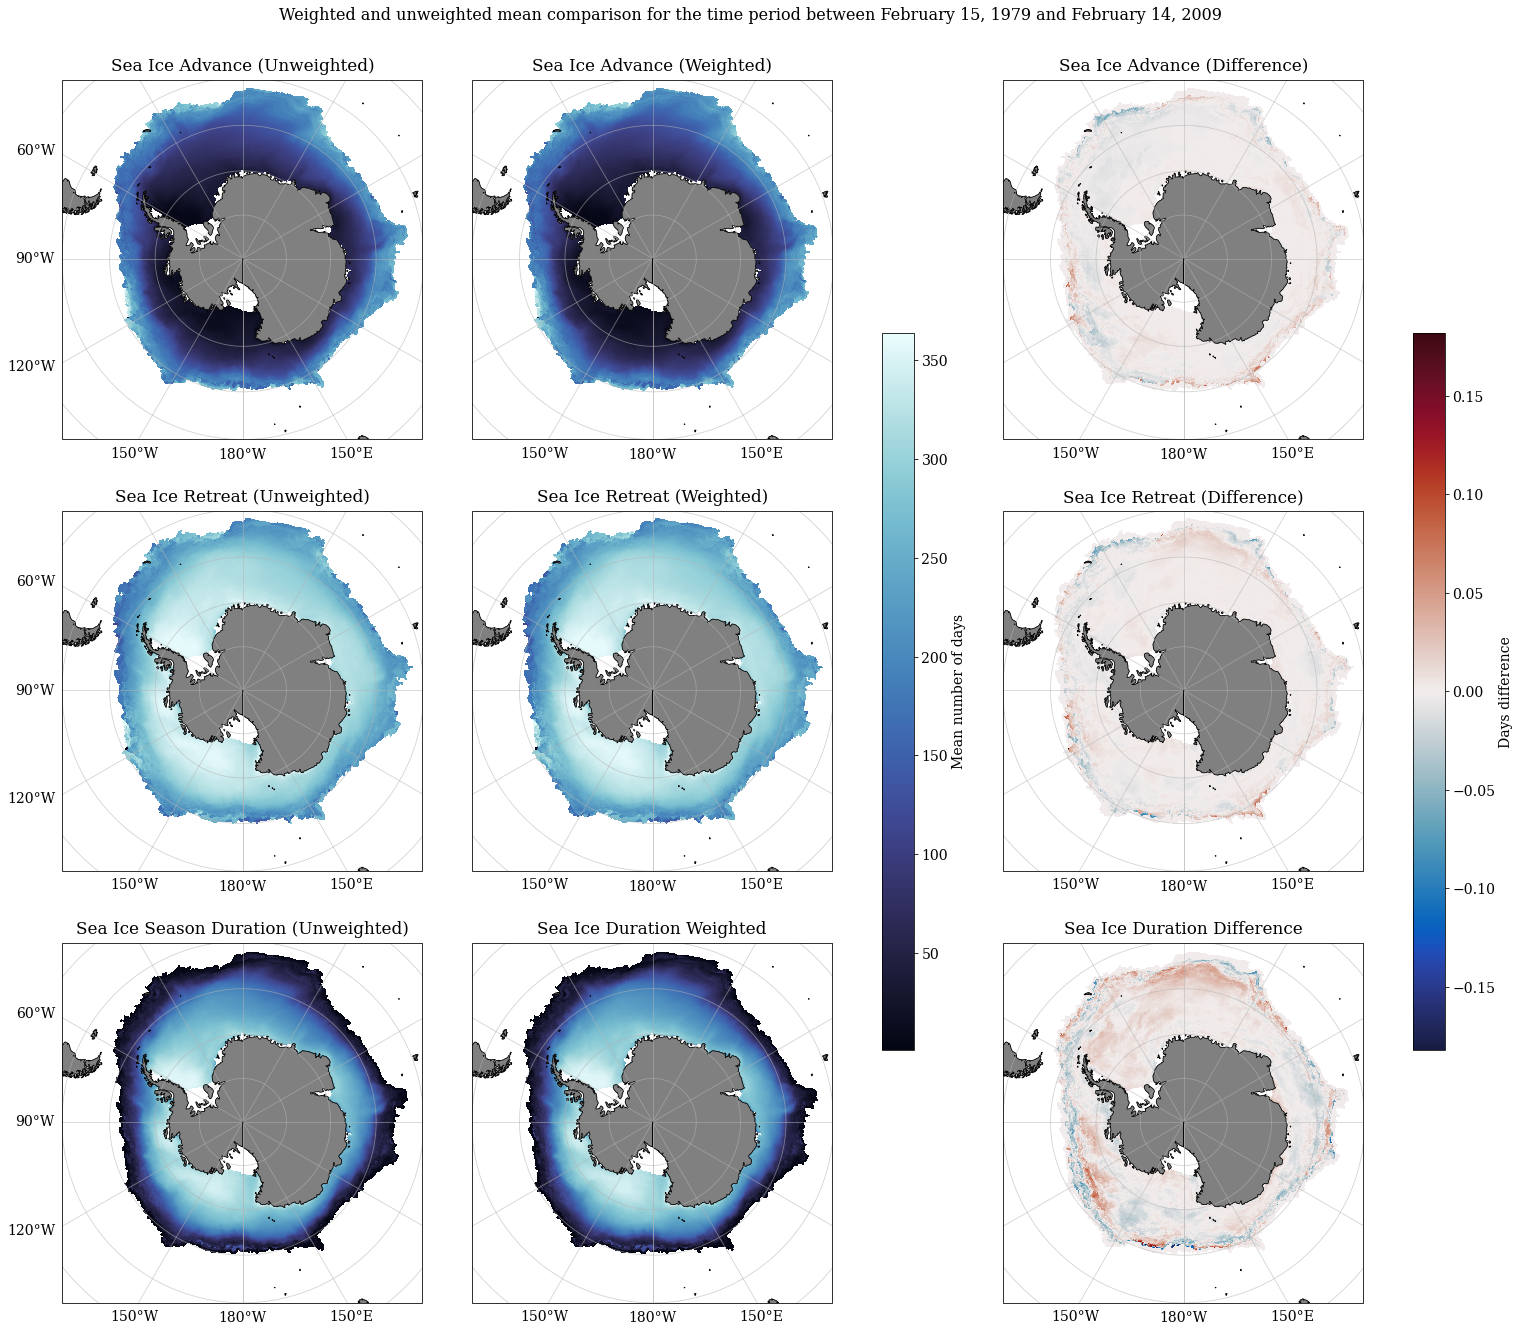

In [33]:
dir_out = r'PROVIDE_FILE_PATH'

#Calling libraries to edit long and lat labels
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#######################################################
#Plotting maps
#Change global font and font size
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', linewidth = 0.5)

########
#Create composite figure using a grid
import matplotlib.gridspec as gridspec
#Top left panel shows sea ice advance, top right panel shows sea ice retreat and bottom panel shows sea ice season duration
fig = plt.figure(figsize = (25.5, 22.5))
#Create a grid layout to place all subplots in one figure - 3x3 grid
gs = gridspec.GridSpec(nrows = 3, ncols = 5, width_ratios = [1, 1, 0.2, 1, 0.2])
#Set up axes
axs = {}

########
#Plot advancing sea ice day
#Add subplot in the first two rows and first two columns, so it is aligned to the top left
axs['adv_un'] = fig.add_subplot(gs[0, 0], projection = projection)
#Add contour plot of sea ice advance
p_adv = base_adv.mean('time').plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = axs['adv_un'],
              #Setting color palette and contour levels
              cmap = cm.cm.ice, add_colorbar = False,
              #Remove colourbar to allow for further manipulation
              transform = ccrs.PlateCarree())
#Add subplot title
axs['adv_un'].set_title('Sea Ice Advance (Unweighted)', y = 1.01)

#Advance weighted
axs['adv_w'] = fig.add_subplot(gs[0, 1], projection = projection)
#Add contour plot of sea ice advance
p_advw = adv_w.plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = axs['adv_w'],
              #Setting color palette and contour levels
              cmap = cm.cm.ice, add_colorbar = False,
              #Remove colourbar to allow for further manipulation
              transform = ccrs.PlateCarree())
#Add subplot title
axs['adv_w'].set_title('Sea Ice Advance (Weighted)', y = 1.01)

######
cb_days = gridspec.GridSpecFromSubplotSpec(5, 2, subplot_spec = gs[:, 2])
cb_days_a = fig.add_subplot(cb_days[1:4, 0])
# add_colorbar = False
plt.colorbar(p_adv, cb_days_a, label = 'Mean number of days')

######
#Advance difference
adv_dif = adv_w-base_adv.mean('time')
axs['adv_d'] = fig.add_subplot(gs[0, 3], projection = projection)
#Add contour plot of sea ice advance
p_advd = adv_dif.plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = axs['adv_d'],
              #Setting color palette and contour levels
              cmap = cm.cm.balance, add_colorbar = False,
              #Remove colourbar to allow for further manipulation
              transform = ccrs.PlateCarree())
#Add subplot title
axs['adv_d'].set_title('Sea Ice Advance (Difference)', y = 1.01)

########
#Plot retreating sea ice day
#Add subplot along the first two rows and the last two columns, so it is aligned to the top right
axs['ret_un'] = fig.add_subplot(gs[1, 0], projection = projection)
p_ret = base_ret.mean('time').plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = axs['ret_un'],
              #Setting color palette and contour levels
              cmap = cm.cm.ice, add_colorbar = False,
              #Remove colourbar to allow for further manipulation
              transform = ccrs.PlateCarree())
#Add subplot title
axs['ret_un'].set_title('Sea Ice Retreat (Unweighted)', y = 1.01)

#Retreat weighted
axs['ret_w'] = fig.add_subplot(gs[1, 1], projection = projection)
#Add contour plot of sea ice advance
p_retw = ret_w.plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = axs['ret_w'],
              #Setting color palette and contour levels
              cmap = cm.cm.ice, add_colorbar = False,
              #Remove colourbar to allow for further manipulation
              transform = ccrs.PlateCarree())
#Add subplot title
axs['ret_w'].set_title('Sea Ice Retreat (Weighted)', y = 1.01)

#Retreat difference
ret_dif = ret_w-base_ret.mean('time')
axs['ret_d'] = fig.add_subplot(gs[1, 3], projection = projection)
#Add contour plot of sea ice advance
p_retw = ret_dif.plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = axs['ret_d'],
              #Setting color palette and contour levels
              cmap = cm.cm.balance, add_colorbar = False,
              #Remove colourbar to allow for further manipulation
              transform = ccrs.PlateCarree())
#Add subplot title
axs['ret_d'].set_title('Sea Ice Retreat (Difference)', y = 1.01)

######    
#Plot sea ice duration
#Add subplot along the last two rows and in the middle two columns (1 and 2)
axs['dur_un'] = fig.add_subplot(gs[2, 0], projection = projection)
#Add contour plot of season duration
p_dur = base_dur.mean('time').plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = axs['dur_un'], 
              #Setting color palette and contour levels
              cmap = cm.cm.ice, add_colorbar = False,
              #Remove colourbar to allow for further manipulation
              transform = ccrs.PlateCarree())
#Add subplot title
axs['dur_un'].set_title('Sea Ice Season Duration (Unweighted)', y = 1.01)

#Duration weighted
axs['dur_w'] = fig.add_subplot(gs[2, 1], projection = projection)
#Add contour plot of sea ice advance
p_durw = dur_w.plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = axs['dur_w'],
              #Setting color palette and contour levels
              cmap = cm.cm.ice, add_colorbar = False,
              #Remove colourbar to allow for further manipulation
              transform = ccrs.PlateCarree())
#Add subplot title
axs['dur_w'].set_title('Sea Ice Duration Weighted', y = 1.01)

#Advance difference
dur_dif = dur_w-base_dur.mean('time')
axs['dur_d'] = fig.add_subplot(gs[2, 3], projection = projection)
#Add contour plot of sea ice advance
p_durd = dur_dif.plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = axs['dur_d'],
              #Setting color palette and contour levels
              cmap = cm.cm.balance, add_colorbar = False,
              #Remove colourbar to allow for further manipulation
              transform = ccrs.PlateCarree())
#Add subplot title
axs['dur_d'].set_title('Sea Ice Duration Difference', y = 1.01)

######
#Colorbar differences
cb_dif = gridspec.GridSpecFromSubplotSpec(5, 2, subplot_spec = gs[:, 4])
cb_dif_a = fig.add_subplot(cb_dif[1:4, 0])
# add_colorbar = False
plt.colorbar(p_advd, cb_dif_a, label = 'Days difference')

######
for ax in axs.values():
    #Remove x and y axes labels
    ax.set_ylabel("")
    ax.set_xlabel("")
    #Coastlines to appear
    ax.coastlines(resolution = '50m')
    #Add feature loaded at the beginning of this section
    ax.add_feature(land_50m)
    #Set the extent of maps
    ax.set_extent([-280, 80, -80, -50], crs = ccrs.PlateCarree())
    #Adding gridlines gridlines - Removing any labels inside the map on the y axis
    gl = ax.gridlines(draw_labels = True, y_inline = False, color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 8
    gl.ypadding = 8
    gl.xlabels_left = False
    gl.ylabels_right = False
    gl.xlabels_right = False
    gl.xlabels_top = False
    #Only include labels on the left side of the subplot if it is not the sea ice retreat subplot
    if ax.colNum == 0:
        gl.ylabels_left = True
    elif ax.colNum != 0:
        gl.ylabels_left = False
    elif ax.rowNum == 3:
        gl.xlabels_bottom = True
    elif ax.rowNum != 3:
        gl.xlabels_bottom = False
        
#Add title to plot
fig.suptitle('Weighted and unweighted mean comparison for the time period between February 15, 1979 and February 14, 2009', y = 0.925, fontsize = 16)
#Save figure
os.makedirs(dir_out, exist_ok = True)
fig.savefig(os.path.join(dir_out, ('Weight_Unweighted_Means1979-2009.png')))